In [1]:
import numpy as np
import pandas as pd

from lingam.utils import make_dot
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor

from lingam.utils import make_dot
from lingam import CausalBasedSimulator, CBSILiNGAM

## テストデータ

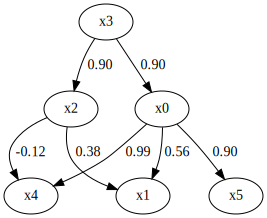

(1000, 5)


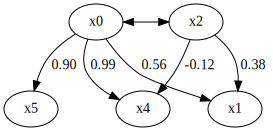

In [2]:
causal_graph = np.array([
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.565,  0.000,  0.377,  0.000,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000],
    [ 0.991,  0.000, -0.124,  0.000,  0.000,  0.000],
    [ 0.895,  0.000,  0.000,  0.000,  0.000,  0.000]
])
display(make_dot(causal_graph))

generate_error = lambda p: np.random.uniform(-p, p, size=1000)

error_vars = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2]
params = [0.5 * np.sqrt(12 * v) for v in error_vars]
e = np.array([generate_error(p) for p in params])

X = np.linalg.pinv(np.eye(len(causal_graph)) - causal_graph) @ e
X = X.T

# x3を潜在変数化
X = np.delete(X, 3, axis=1)
print(X.shape)

# 今回はデータフレーム
X = pd.DataFrame(X, columns=[f"x{i}" for i in [0, 1, 2, 4, 5]])

causal_graph_latent = np.delete(causal_graph, 3, axis=1)
causal_graph_latent = np.delete(causal_graph_latent, 3, axis=0)
causal_graph_latent[0, 2] = np.nan
causal_graph_latent[2, 0] = np.nan
display(make_dot(causal_graph_latent, labels=list(X.columns)))

## CausalBasedSimulator

In [3]:
# コンストラクタは引数なし
sim = CausalBasedSimulator()

# 訓練
#cd_algo_name
sim.train(X, causal_graph_latent, cd_algo_name="BottomUpParceLiNGAM", models=None)

### train_result_

In [4]:
# 訓練結果(sim.trian_result_)
display(Markdown("### sim.train_result_"))
df = {}
for key, result in sim.train_result_.items():
    df[key] = {
        "キー": key,
        "モデル": result["model"],
        "親リスト": result["parent_names"],
        "MLモデル予測値(のshape)": None if result["predicted"] is None else result["predicted"].shape,
        "MLモデル残差(のshape)": None if result["residual"] is None else result["residual"].shape,
    }
display(pd.DataFrame(df).T)

### sim.train_result_

,キー,モデル,親リスト,MLモデル予測値(のshape),MLモデル残差(のshape)
x0,x0,None,[],None,"(1000,)"
x1,x1,LinearRegression(),"[x0, x2]","(1000,)","(1000,)"
x2,x2,None,[],None,"(1000,)"
x4,x4,LinearRegression(),"[x0, x2]","(1000,)","(1000,)"
x5,x5,LinearRegression(),[x0],"(1000,)","(1000,)"


### run()

#### オプションなし

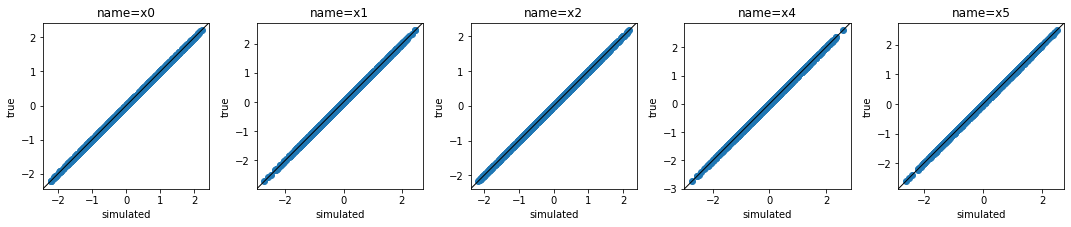

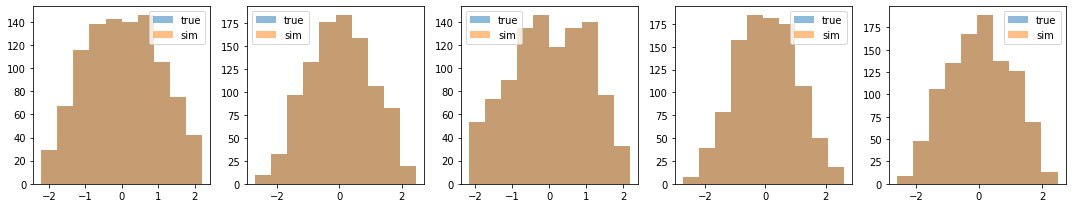

#### shuffle_residual=True

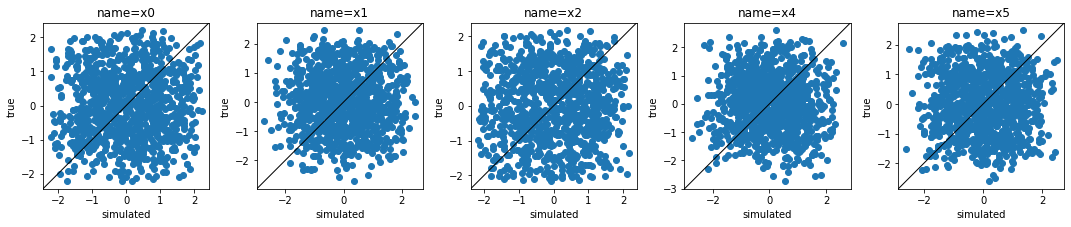

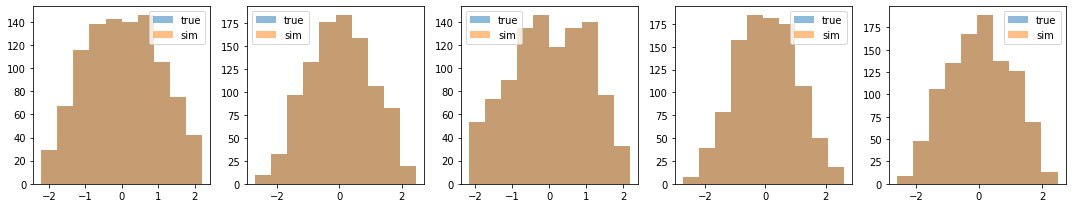

In [5]:
def vis(simulated, data):
    n_features = len(causal_graph_latent)
    fig, axes = plt.subplots(1, n_features, figsize=(n_features*3, 3))
    for i in range(n_features):
        axes[i].scatter(simulated.iloc[:, i], data.iloc[:, i])
        axes[i].set_aspect("equal", "box")
        axes[i].axline((0, 0), (1, 1), color="black", lw=1)
        axes[i].set_xlabel("simulated")
        axes[i].set_ylabel("true")
        axes[i].set_title(f"name={simulated.columns[i]}")
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, n_features, figsize=(n_features*3, 3))
    for i in range(n_features):
        range_ = [*data.iloc[:, i], *simulated.iloc[:, i]]
        range_ = min(range_), max(range_)
        
        axes[i].hist(data.iloc[:, i], label="true", range=range_, alpha=0.5)
        axes[i].hist(simulated.iloc[:, i], label="sim", range=range_, alpha=0.5)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

# シミュレーション
display(Markdown("#### オプションなし"))
simulated = sim.run()
vis(simulated, X)

# シミュレーション2: 誤差変数並び替え
display(Markdown("#### shuffle_residual=True"))
simulated = sim.run(shuffle_residual=True)
vis(simulated, X)

#### changing_modelsのcoefsを指定(5を外生化)
5が孤立しつつ訓練時の残差になる。他変数への影響はなし。

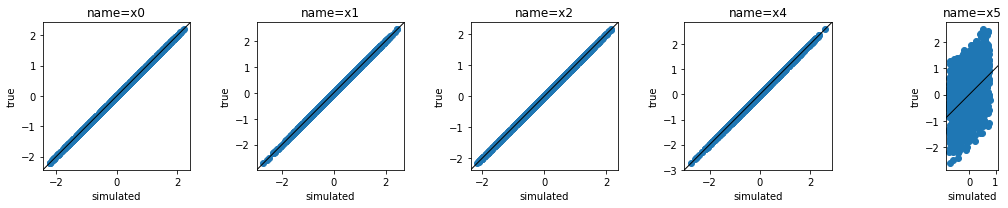

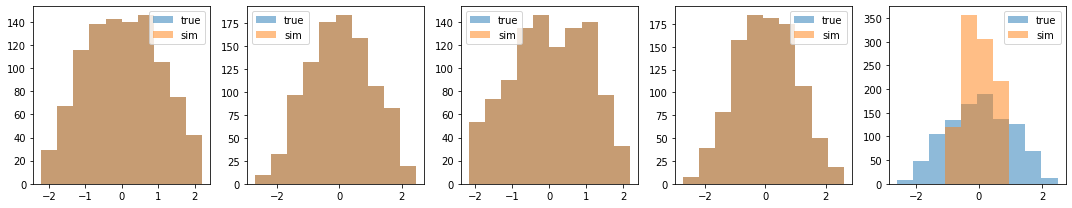

#### changing_modelsのcoefsを指定(5->0の向きを逆に)
もうひとつの外生変数であるx2に影響は及ばない。

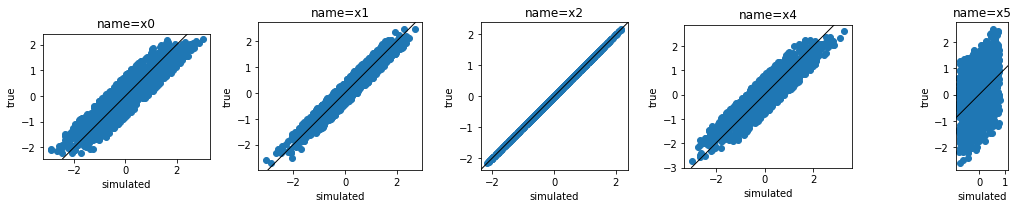

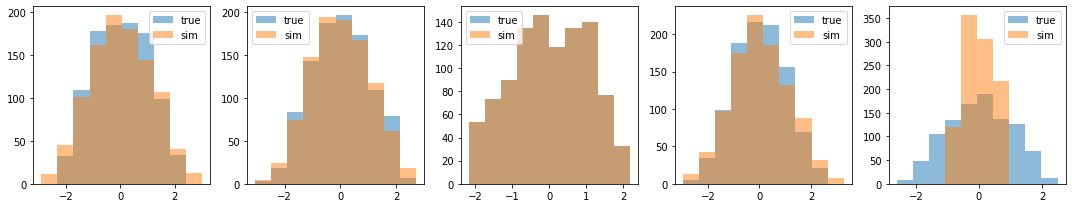

#### changing_modelsのcoefsを指定(2を外生化)
"2"を変更したため"1"と"4"にのみ影響が出る。

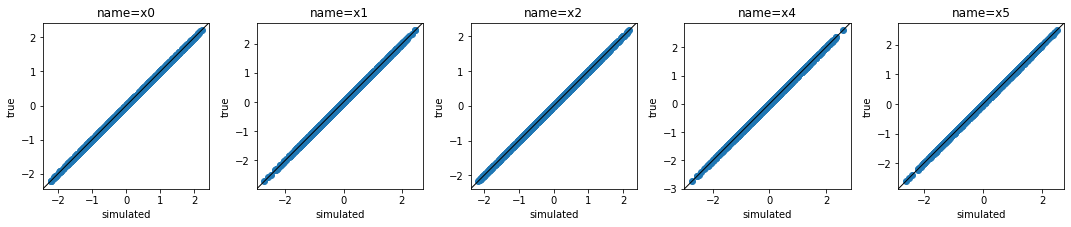

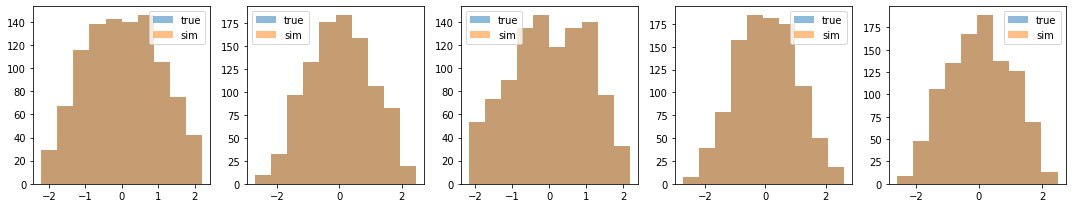

In [6]:
# シミュレーション3: モデル変更(訓練済みモデル指定なしで係数のみ設定)　
display(Markdown("#### changing_modelsのcoefsを指定(5を外生化)\n5が孤立しつつ訓練時の残差になる。他変数への影響はなし。"))
changing_models = {
    "x5": {"parent_names": [], "coefs": []},
}
simulated = sim.run(changing_models=changing_models)
vis(simulated, X)

# シミュレーション4: モデル変更(訓練済みモデル指定なしで係数のみ設定)　
display(Markdown("#### changing_modelsのcoefsを指定(5->0の向きを逆に)\nもうひとつの外生変数であるx2に影響は及ばない。"))
changing_models = {
    "x0": {"parent_names": ["x5"], "coefs": [-1.1]},
    "x5": {"parent_names": [], "coefs": []},
}
simulated = sim.run(changing_models=changing_models)
vis(simulated, X)

# シミュレーション5: モデル変更(訓練済みモデルの設定)　
display(Markdown("#### changing_modelsのcoefsを指定(2を外生化)\n\"2\"を変更したため\"1\"と\"4\"にのみ影響が出る。"))

# 常に0.0を返すダミー
ml_model = DummyRegressor(strategy="constant", constant=0.0)
ml_model.fit([[0]], [[0]])

changing_models = {
    "x2": {"parent_names": [], "model": ml_model},
}
simulated = sim.run(changing_models=changing_models)
vis(simulated, X)